# Visualize the word origins for tea on a map
Author(s): Amanda R.H. Ng<br>
Language: `python` version 3.12.7<br>
Created on: 2025.09.06<br>
Updated on: 2025.09.07<br>
Status: In-progress

The words for tea across languages are generally derived from _cha_ or _te_ depending on the trading routes of purchasing, buying or growing tea. We can visualize these word origins on a world map, where the countries are color-coded based on the origin of the word of tea of the commonly spoken language(s).

In [1]:
# Import libraries
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## Standarize the countries in each dataset
We're using three datasets:
- languages and their tea word origins compiled by Dahl (2013)
- countries and their commonly spoken language(s) compiled by Negret _et al._ (2022)
- shapes of countries distributed by Natural Earth (2009)

The shapes of the countries I use here is a low-resolution dataset. Many small countries do not have their shape listed in the dataset as a result, which is an okay compromise in this case since we're plotting a global map and we can't really spot the smaller countries by eye.

Since we're ultimately visualizing the data on the global map, we'll focus on the countries listed in the shapes dataset.

In [2]:
# Load the country shapes
# Note: I got downloaded the raw data from https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip on 2025.08.31. I unzipped the file and loaded the shp file.
world_gdf = gpd.read_file("raw_data/ne_110m_admin_0_countries.shp")
world_gdf.head()

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
0,Admin-0 country,1,6,Fiji,FJI,0,2,Sovereign country,1,Fiji,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((180 -16.06713, 180 -16.55522, ..."
1,Admin-0 country,1,3,United Republic of Tanzania,TZA,0,2,Sovereign country,1,United Republic of Tanzania,...,None,None,None,None,None,None,None,None,None,"POLYGON ((33.90371 -0.95, 34.07262 -1.05982, 3..."
2,Admin-0 country,1,7,Western Sahara,SAH,0,2,Indeterminate,1,Western Sahara,...,Unrecognized,Unrecognized,Unrecognized,None,None,Unrecognized,None,None,None,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Admin-0 country,1,2,Canada,CAN,0,2,Sovereign country,1,Canada,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-122.84 49, -122.97421 49.0025..."
4,Admin-0 country,1,2,United States of America,US1,1,2,Country,1,United States of America,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-122.84 49, -120 49, -117.0312..."


In [ ]:
# Get the column names in the dataframe of country shapes
for col in world_gdf.columns:
    print(col)

featurecla
scalerank
LABELRANK
SOVEREIGNT
SOV_A3
ADM0_DIF
LEVEL
TYPE
TLC
ADMIN
ADM0_A3
GEOU_DIF
GEOUNIT
GU_A3
SU_DIF
SUBUNIT
SU_A3
BRK_DIFF
NAME
NAME_LONG
BRK_A3
BRK_NAME
BRK_GROUP
ABBREV
POSTAL
FORMAL_EN
FORMAL_FR
NAME_CIAWF
NOTE_ADM0
NOTE_BRK
NAME_SORT
NAME_ALT
MAPCOLOR7
MAPCOLOR8
MAPCOLOR9
MAPCOLOR13
POP_EST
POP_RANK
POP_YEAR
GDP_MD
GDP_YEAR
ECONOMY
INCOME_GRP
FIPS_10
ISO_A2
ISO_A2_EH
ISO_A3
ISO_A3_EH
ISO_N3
ISO_N3_EH
UN_A3
WB_A2
WB_A3
WOE_ID
WOE_ID_EH
WOE_NOTE
ADM0_ISO
ADM0_DIFF
ADM0_TLC
ADM0_A3_US
ADM0_A3_FR
ADM0_A3_RU
ADM0_A3_ES
ADM0_A3_CN
ADM0_A3_TW
ADM0_A3_IN
ADM0_A3_NP
ADM0_A3_PK
ADM0_A3_DE
ADM0_A3_GB
ADM0_A3_BR
ADM0_A3_IL
ADM0_A3_PS
ADM0_A3_SA
ADM0_A3_EG
ADM0_A3_MA
ADM0_A3_PT
ADM0_A3_AR
ADM0_A3_JP
ADM0_A3_KO
ADM0_A3_VN
ADM0_A3_TR
ADM0_A3_ID
ADM0_A3_PL
ADM0_A3_GR
ADM0_A3_IT
ADM0_A3_NL
ADM0_A3_SE
ADM0_A3_BD
ADM0_A3_UA
ADM0_A3_UN
ADM0_A3_WB
CONTINENT
REGION_UN
SUBREGION
REGION_WB
NAME_LEN
LONG_LEN
ABBREV_LEN
TINY
HOMEPART
MIN_ZOOM
MIN_LABEL
MAX_LABEL
LABEL_X
LABEL_Y
NE_ID
WIKIDA

In [ ]:
# Get the countries in the shapes file
# Note: I am using the "ADM0_A3" which is a unique identifier for each country
countries = set(world_gdf["ADM0_A3"].tolist())
print(f"Number of countries in shapes file: {len(countries)}")

Number of countries in shapes file: 177


## Map the tea word origins to the commonly spoken languages of each country
1. For each country, identify the commonly spoken language(s).
2. Our reference dataset of languages and their tea word origins doesn't comprehensively cover all languages, so we need to check if most (i.e. more than 50%) of a country's commonly spoken languages is reflected in our reference dataset.
3. If a country has more than one tea word origin, we'll get the most common tea word origin out of all the languages spoken in the country.

⚠️ Note: I make an assumption in this analysis that all commonly spoken languages in a country are equally spoken, which isn't true. In Singapore, for example, the commonly spoken languages listed in our reference dataset are: English, Malay, Chinese and Tamil. These four languages, however, do not have equal numbers of speakers in Singapore.

In [4]:
# Load the word origins for tea file
# Note: I downloaded the data from https://wals.info/feature/138A#2/20.0/147.3 on 2025.08.25.
origins = pd.read_csv(
    "raw_data/2013_dahl_words_for_tea.txt",
    skiprows = 6,
    sep = "\t"
)
origins.sample(n = 5)

,wals code,name,value,description,latitude,longitude,genus,family,area
137,mym,Malayalam,1,Words derived from Sinitic cha,10.000000,76.500000,Dravidian,Dravidian,Lexicon
88,ita,Italian,2,Words derived from Min Nan Chinese te,43.000000,12.000000,Romance,Indo-European,Lexicon
202,taj,Tajik,1,Words derived from Sinitic cha,38.666667,70.000000,Iranian,Indo-European,Lexicon
2,ace,Acehnese,2,Words derived from Min Nan Chinese te,5.500000,95.500000,Malayo-Sumbawan,Austronesian,Lexicon
13,ata,Atayal,3,Others,24.500000,121.333333,Atayalic,Austronesian,Lexicon


In [5]:
# Have a look at the dataframe of commonly spoken languages
# Note: I downloaded the data which is a supplementary file from https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0267151
spoken_languages = pd.read_excel(
    "raw_data/2022_Amano_LanguagesSpokenByCountry.xlsx"
)
spoken_languages.sample(n = 5)

,Country,adm0_a3,Afrikaans,Albanian,Amharic,Arabic,Armenian,Asante,Aymara,Azerbaijani,...,Turkish,Turkmen,Tuvaluan,Ukrainian,Urdu,Uzbek,Vietnamese,Languages CIA factsheet,Additional source,Additional source information
193,Saint Vincent and the Grenadines,VCT,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"English, Vincentian Creole English, French patois",https://www.britannica.com/place/Saint-Vincent...,English (Official)
177,Peru,PER,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,"Spanish (official) 82.9%, Quechua (official) 1...",NaN,NaN
187,Saint Barthelemy,BLM,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"French (primary), English",https://www.britannica.com/place/Saint-Barthelemy,French (Official)
139,Malaysia,MYS,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Bahasa Malaysia (official),NaN,NaN
40,Cameroon,CMR,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"English (official), French (official)",NaN,NaN


In [54]:
def map_country_to_tea_word(
    spoken_languages = spoken_languages,
    origins = origins,
    countries = countries
):
    # Make a reference dictionary for mapping the values in the origins to
    # the tea word origin
    value_map = {
        1: "cha",
        2: "te",
        3: "others"
    }

    # Trim the list of commonly spoken languages to the countries in our map
    spoken_languages = spoken_languages[spoken_languages["adm0_a3"].isin(countries)]

    # Get languages listed in the spoken_languages dataset
    ignore_cols = [
        "Country", "adm0_a3", "Languages CIA factsheet", "Additional source",
        "Additional source information"
    ]
    languages = [lang for lang in spoken_languages.columns if lang not in ignore_cols]

    # Get the languages with known tea word origins
    origin_languages = set(origins["name"].tolist())

    # Initialize variable for tracking the number of countries with
    # tea word origins that map to at least 50% of commonly spoken
    # languages
    n_mappable_countries = 0

    # Initialize a list to collect country → tea word origin mappings
    country_origin_rows = []

    # Re-organize the spoken languages to a dataframe where each row is a
    # commonly spoken language assigned to its associated country
    for i in spoken_languages.index:

        # Get the country
        country = spoken_languages.loc[i, "Country"]
        country_id = spoken_languages.loc[i, "adm0_a3"]

        # Get the commonly spoken languages for the country
        country_languages = set()
        for lang in languages:
            if spoken_languages.loc[i, lang] == 1:
                country_languages.add(lang)

        # Get the languages which are commonly spoken in the country
        # with known tea word origins
        findable_languages = country_languages.intersection(origin_languages)

        # Check if more than 50% of languages spoken in the country
        # have their tea words origins compiled in the reference dataset
        if len(findable_languages) > int(len(country_languages)*0.5):

            # Track the number of mappable countries
            n_mappable_countries += 1

            # Get the most common tea word origin
            origins_subset = origins[origins["name"].isin(findable_languages)]
            common_value = origins_subset["value"].value_counts().idxmax()
            tea_word_origin = value_map[common_value]

        # Not enough data to determine origin
        else:
            tea_word_origin = "insufficient data"
        
        # Store the result
        country_origin_rows.append({
            "country": country,
            "adm0_a3": country_id,
            "tea_word_origin": tea_word_origin
        })

    # Create dataframe from the collected rows of results
    country_tea_origin = pd.DataFrame(country_origin_rows)

    # Print summary of countries with sufficient tea word origin data
    print(rf"""
Number of countries for which the tea word origin data is
available for > 50% of commonly spoken languages: {n_mappable_countries}/{len(countries)}""")

    return(country_tea_origin)

country_tea_origin = map_country_to_tea_word()
country_tea_origin.head()


Number of countries for which the tea word origin data is
available for > 50% of commonly spoken languages: 107/177


,country,adm0_a3,tea_word_origin
0,Afghanistan,AFG,insufficient data
1,Albania,ALB,cha
2,Algeria,DZA,insufficient data
3,Angola,AGO,cha
4,Antarctica,ATA,insufficient data


In [55]:
# Export the country_tea_origin
country_tea_origin.to_csv("country_tea_origin.csv", index = False)

## Use the annotation for tea word origins directly
The dataset for tea word origins actually contains the latitude and altitude for which the language is from, and we can use that to assign countries with "insufficient data" based on their commonly spoken languages.

In [80]:
def map_tea_word_to_country(
    world_gdf = world_gdf,
    origins = origins,
    country_tea_origin = country_tea_origin,
    value_map = {
        1: "cha",
        2: "te",
        3: "others"
    }
):
    # Get the countries with insufficient data
    countries = country_tea_origin[country_tea_origin["tea_word_origin"] == "insufficient data"]["adm0_a3"].tolist()

    # Trim the world_gdf to countries with insufficient data
    world_gdf = world_gdf[world_gdf["ADM0_A3"].isin(countries)]

    # Convert the latitude and longitude data into Point objects
    geometry = [Point(xy) for xy in zip(origins["longitude"], origins["latitude"])]
    origins = gpd.GeoDataFrame(origins, geometry = geometry, crs = "EPSG:4326")

    # Assign each tea point to a country
    assigned_origins = gpd.sjoin(
        origins,
        world_gdf,
        how = "left",
        predicate = "within"
    )
    assigned_origins = assigned_origins[assigned_origins["ADM0_A3"].notna()]

    # Group by country and pick the most frequent value
    dominant_value = assigned_origins.groupby("ADM0_A3")["value"].agg(lambda x: x.value_counts().idxmax()).reset_index()
    dominant_value.columns = ["adm0_a3", "tea_word_origin"]
    dominant_value["tea_word_origin"] = dominant_value["tea_word_origin"].map(value_map)

    # Create a copy of the original df to update
    updated_df = country_tea_origin.copy()

    # Update only rows with insufficient data
    for idx, row in dominant_value.iterrows():
        mask = (updated_df["adm0_a3"] == row["adm0_a3"]) & (updated_df["tea_word_origin"] == "insufficient data")
        updated_df.loc[mask, "tea_word_origin"] = row["tea_word_origin"]

    return(updated_df)

country_tea_origin_updated = map_tea_word_to_country()
country_tea_origin_updated.head()

,country,adm0_a3,tea_word_origin
0,Afghanistan,AFG,cha
1,Albania,ALB,cha
2,Algeria,DZA,others
3,Angola,AGO,cha
4,Antarctica,ATA,insufficient data


## Manually update tea word origins of countries based on prior knowledge

In [83]:
country_tea_origin_updated[country_tea_origin_updated["tea_word_origin"] == "insufficient data"]

,country,adm0_a3,tea_word_origin
4,Antarctica,ATA,insufficient data
16,Bhutan,BTN,insufficient data
17,Bolivia (Plurinational State of),BOL,insufficient data
21,Brunei Darussalam,BRN,insufficient data
36,Croatia,HRV,insufficient data
38,Cyprus,CYP,insufficient data
39,Cyprus North,CYN,insufficient data
48,Eritrea,ERI,insufficient data
50,Eswatini,SWZ,insufficient data
53,Fiji,FJI,insufficient data


In [ ]:
# CONTINUE HERE

## Visualize the countries by their common tea word origin

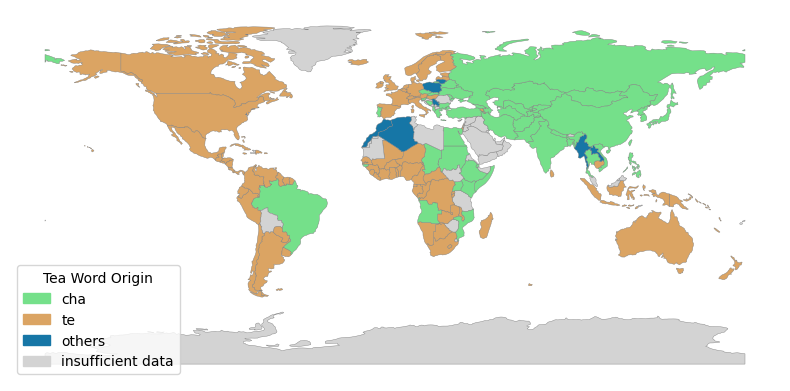

In [81]:
def plot_tea_map(
    world_gdf = world_gdf,
    country_tea_origin = country_tea_origin_updated,
    color_map = {
        "cha": "#75E08A",  # Light green
        "te": "#DBA463",  # Light brown
        "others": "#1676A6",  # Dark blue
        "insufficient data": "lightgray"
    },
    xlim = (None, None),
    ylim = (None, None),
    output_path = "tea_map.png",
    dpi = 300
):
    # Add the tea word origin for each country in the world map
    world_gdf = world_gdf[["ADM0_A3", "geometry"]]
    world_gdf = world_gdf.merge(
        country_tea_origin,
        left_on = "ADM0_A3",
        right_on = "adm0_a3",
        how = "left"
    )
    world_gdf["tea_word_origin"] = world_gdf["tea_word_origin"].fillna("insufficient data")

    # Map the colors for the country based on their tea word origin
    world_gdf["color"] = world_gdf["tea_word_origin"].map(color_map)

    # Build the plot
    fig, ax = plt.subplots(figsize = (8, 8))
    world_gdf.plot(
        ax = ax,
        color = world_gdf["color"],
        edgecolor = "gray",
        linewidth = 0.3
    )

    # Set plot limits if provided
    if xlim != (None, None):
        ax.set_xlim(xlim)
    if ylim != (None, None):
        ax.set_ylim(ylim)

    # Custom legend
    legend_handles = []
    for label, color in color_map.items():
        legend_handles.append(
            mpatches.Patch(color = color, label = label)
        )
    plt.legend(
        handles = legend_handles,
        title = "Tea Word Origin",
        loc = "lower left"
    )

    # Plot aesthetics
    ax.axis('off')
    plt.tight_layout()

    # Export plot
    plt.savefig(
        output_path,
        transparent = True,
        dpi = dpi,
        bbox_inches = "tight"
    )

    # Show the plot
    plt.show()

    return
plot_tea_map()

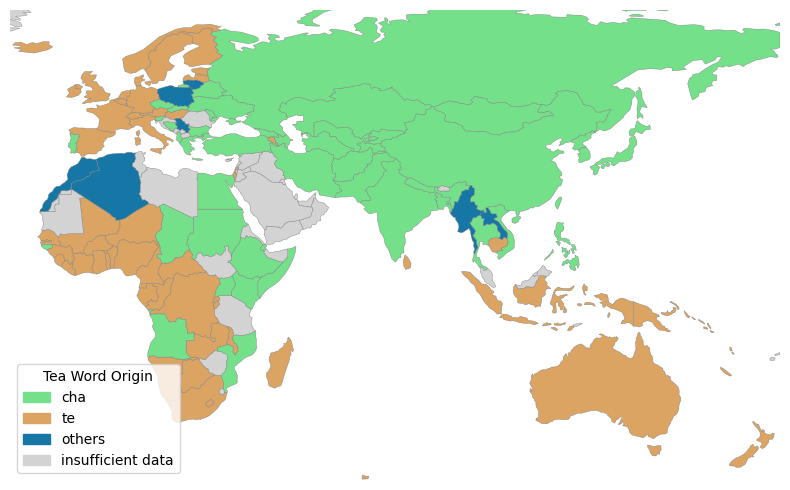

In [82]:
plot_tea_map(
    xlim = (-25, 180),
    ylim = (-50, 75)
)